# Программирование на `C++` и `Python`.
## Дополнительная лекция. Численная оптимизация
Воробьев Виталий, 2020.12.16

Постановка задачи:

$$
\mathrm{argmin}\ f\left(\vec{p}\right)
$$

## Часть 1. Инструменты

### 1.1. Scipy optimize
`optimize.minimize` - численный поиск *локального* минимума скалярной функции нескольких переменных

In [1]:
import numpy as np
from scipy import optimize

$$
f_1(x) = x_0^2 + (x_1 - 0.5)^2 + (x_2 - 1)^2 + \dots
$$

In [2]:
def f1(x):
    return np.sum((x - 0.5*np.arange(x.size))**2)

In [3]:
def f1_deriv(x):
    return 2*x - np.arange(x.size)

In [4]:
res = optimize.minimize(f1, np.zeros(7))
print(res.x)
print(f'f1 calls: {res.nfev}')

[0.         0.50000045 0.99999956 1.50000002 2.00000047 2.49999958
 3.00000003]
f1 calls: 36


In [5]:
res2 = optimize.minimize(f1, np.zeros(7), method='BFGS')
print(res2.x)
print(f'f1 calls: {res2.nfev}')

[0.         0.50000045 0.99999956 1.50000002 2.00000047 2.49999958
 3.00000003]
f1 calls: 36


In [6]:
res3 = optimize.minimize(f1, np.zeros(7), method='BFGS', jac=f1_deriv)
print(res3.x)
print(f'f1 calls: {res3.nfev}')

[0.  0.5 1.  1.5 2.  2.5 3. ]
f1 calls: 4


In [7]:
res4 = optimize.minimize(f1, np.zeros(7), method='Newton-CG', jac=f1_deriv)
print(res4.x)
print(f'f1 calls: {res4.nfev}')

[0.  0.5 1.  1.5 2.  2.5 3. ]
f1 calls: 3


### 1.2. Tensorflow

In [8]:
import tensorflow as tf
import tensorflow.keras as tfk

In [9]:
# optim = tfk.optimizers.Adam()
optim = tfk.optimizers.SGD(learning_rate=0.1)

In [10]:
tfvar = tf.Variable(np.ones(7, dtype=np.float32))

def f1tf():
    return tf.math.reduce_sum((tfvar - 0.5*tf.range(tfvar.shape[0], dtype=float))**2)

In [11]:
for _ in range(100):
    fcalls = optim.minimize(f1tf, [tfvar]).numpy()
print(tfvar.numpy())
print(f'f1 calls: {fcalls}')

[2.0370368e-10 5.0000012e-01 1.0000000e+00 1.4999998e+00 1.9999998e+00
 2.4999995e+00 2.9999995e+00]
f1 calls: 100


### 1.3. iMinuit

In [12]:
from iminuit import Minuit

In [13]:
def fcn(x, y):
    return 1 + 3*x + 6*y - 2*x*y + x**2 + 9*y**2

In [14]:
x, y = np.meshgrid(np.linspace(-10, 5, 100), np.linspace(-5, 5, 100))

In [15]:
import matplotlib.pyplot as plt

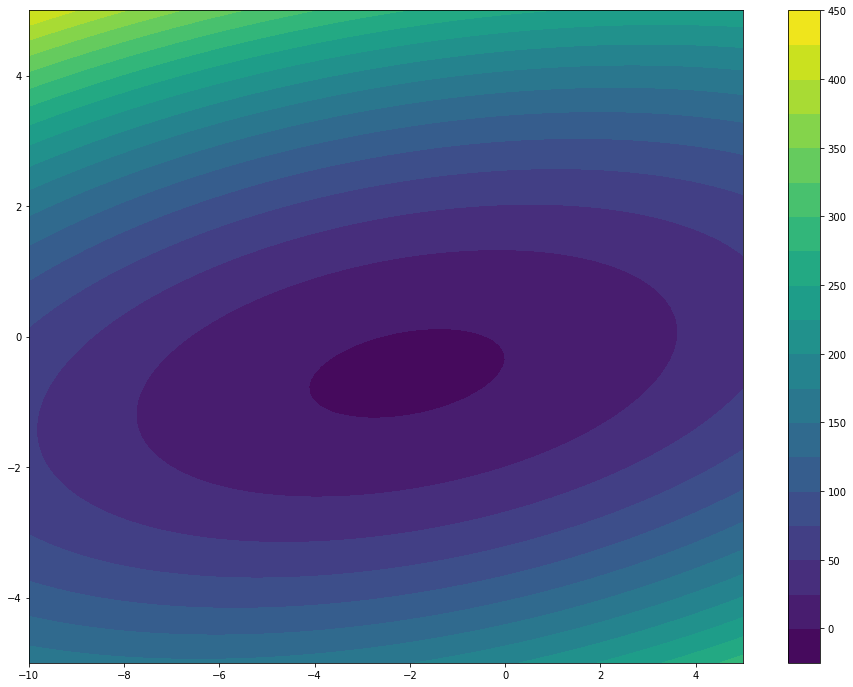

In [16]:
plt.figure(figsize=(16, 12))
c = plt.contourf(x, y, fcn(x,y), levels=20)
plt.colorbar(c);

In [17]:
m = Minuit(fcn, x=0, error_x=0.1, y=0, error_y=0.1, errordef=1)

In [18]:
mres = m.migrad()
mres

------------------------------------------------------------------
| FCN = -3.781                  |      Ncalls=31 (31 total)      |
| EDM = 4.34E-25 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x    |   -2.1    |    1.1    |            |            |         |         |       |
| 1 | y    |   -0.6    |    0.4    |            |            |         |         |       |
------------------------------------------------------------------------------------------

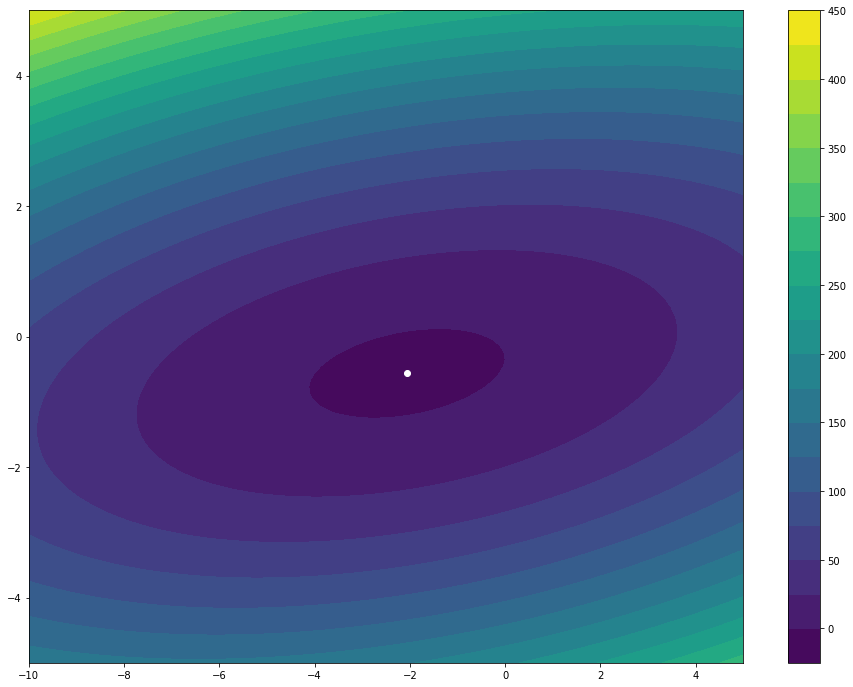

In [19]:
plt.figure(figsize=(16, 12))
c = plt.contourf(x, y, fcn(x,y), levels=20)
plt.colorbar(c);
plt.plot([mres.params[0].value], mres.params[1].value, 'ow');

## Часть 2. Алгоритмы поиска минимума (краткое обсуждение идеи)

Предполагаем, что некоторая функция $f(x)$ - гладкая и выпуклая. Тогда в минимуме функция может быть аппроксимирована параболоидом:

$$f(x)\approx f(x_0) + \frac{1}{2}(x-x_0)^T\mathbf{H}(x_0)(x-x_0)$$

Матрица Гессе (hessian):

$$H_{ij}\equiv \frac{\partial^2 f}{\partial x_i \partial x_j}$$

Идея - делать шаги в направлении антиградиента (градиентный спуск):

$$x_{i+1} = x_i - \lambda\cdot\nabla f(x_i)$$

Как выбрать величину $\lambda$?

* $\lambda = \mathrm{const}$
* Парабалоид: $\lambda = H^{-1}$
* Метод сопряженных градиентов (`Newton-CG`)
* Метод моментов
* RMS prop
* Adam
* ...

In [20]:
def minimize(f, grad, x0, lam=0.1, maxit=100, eps=1e-6):
    fcur = f(x0)
    for _ in range(maxit):
        x0 = x0 - lam * grad(x0)
        fnew = f(x0)
        if np.abs(fcur - fnew) < eps:
            print(f'Converged {np.abs(fcur - fnew)*10**6:.3f}e-6')
            break
        fcur = fnew
    return (fcur, x0)

In [21]:
def f2(x):
    return np.sum((x - np.array([2, 0.3]))**2)

def f2_grad(x):
    return 2 * (x - np.array([2, 0.3]))

In [22]:
fmin, pars = minimize(f2, f2_grad, np.array([0., 1.]), lam=1.e-1, maxit=100)
fmin, pars

Converged 0.649e-6


(1.8037879546808378e-06, array([1.99898588, 0.30035494]))

## Часть 3. Применение алгоритмов оптимизации

### Аппроксимация по точкам

In [23]:
x = np.linspace(0, 4, 10)
data = np.sin(x) + 0.05*np.random.default_rng(seed=1).poisson(4, 10)
data

array([ 0.25      ,  0.57995636,  1.02637192,  1.0719379 ,  1.2786557 ,
        0.99522006,  0.70727263,  0.13047682, -0.05224065, -0.5568025 ])

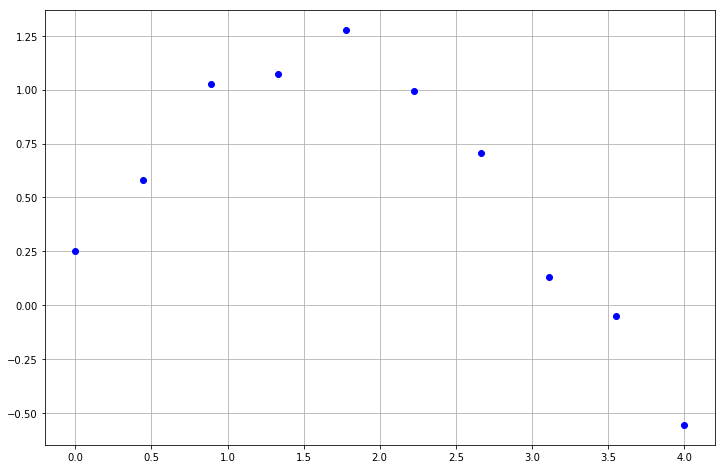

In [24]:
plt.figure(figsize=(12,8))
plt.plot(x, data, 'bo');
plt.grid()

In [25]:
def curve(x, a0, a1, a2, a3):
    return np.polynomial.Polynomial([a0, a1, a2, a3])(x)

res = optimize.curve_fit(curve, x, data)
res

(array([ 0.17427878,  1.44050476, -0.59316933,  0.04652551]),
 array([[ 0.01259369, -0.0218492 ,  0.01028316, -0.0014207 ],
        [-0.0218492 ,  0.06606127, -0.03805445,  0.0058477 ],
        [ 0.01028316, -0.03805445,  0.02386014, -0.00385301],
        [-0.0014207 ,  0.0058477 , -0.00385301,  0.00064217]]))

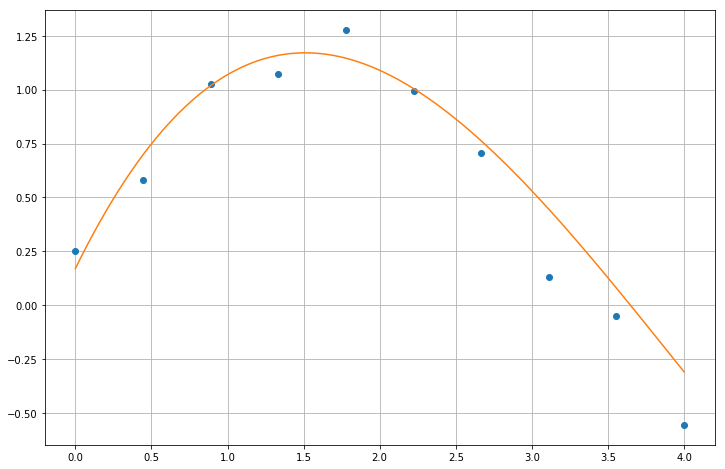

In [26]:
fit = np.polynomial.Polynomial([0.17, 1.44, -0.59, 0.05])
plt.figure(figsize=(12,8))
plt.plot(x, data, 'o');
x0 = np.linspace(0, 4, 100)
plt.plot(x0, fit(x0))
plt.grid()

Root mean squared
$$\mathrm{MSE} = \frac{1}{N}\sum_i \left(y_i - f(x_i)\right)^2\to\mathrm{min}$$

In [27]:
def mse(pars):
    pol = np.polynomial.Polynomial(pars)
    return np.mean((pol(x) - data) ** 2)

def mse_deriv_numeric(pars, eps=1.e-6):
    deriv = []
    for i in range(pars.size):
        pars_posi, pars_nega = pars.copy(), pars.copy()
        pars_posi[i] += eps
        pars_nega[i] -= eps
        deriv.append((mse(pars_posi) - mse(pars_nega)) / (2*eps))
    return np.array(deriv)

def mse_deriv(pars):
    pol = np.polynomial.Polynomial(pars)
    deltay = pol(x) - data
    return 2 * np.array([np.dot(deltay, x**deg) for deg in range(pars.size)]) / deltay.size

In [28]:
pars0 = np.array([0.3, 1.5, -0.7, 0.0])
fmin, pars = minimize(f=mse, grad=mse_deriv, x0=pars0, lam=1.e-6, maxit=5000)
pars

Converged 0.999e-6


array([ 0.3012087 ,  1.50483679, -0.68265536,  0.06265195])

In [29]:
mse(pars0), mse(pars), mse([0.17, 1.44, -0.59, 0.05])

(3.556414796509563, 0.016035796744407416, 0.022572009290284883)

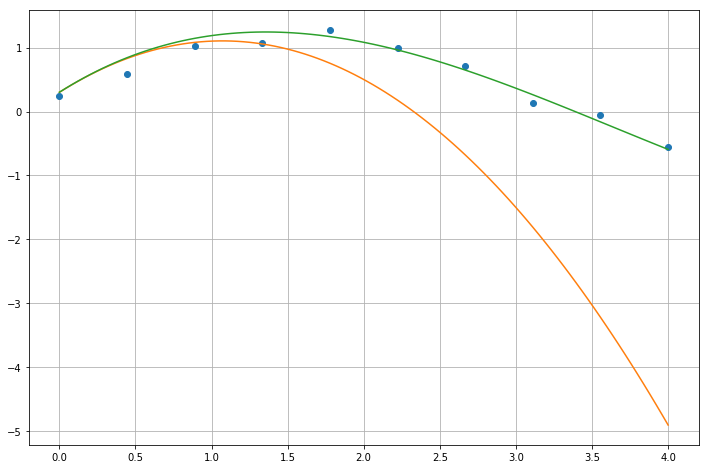

In [30]:
fit0 = np.polynomial.Polynomial(pars0)
fit1 = np.polynomial.Polynomial(pars)
plt.figure(figsize=(12,8))
plt.plot(x, data, 'o');
x0 = np.linspace(0, 4, 100)
plt.plot(x0, fit0(x0))
plt.plot(x0, fit1(x0))
plt.grid()

## Данные с ошибками

In [31]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [32]:
x = np.linspace(0, 4, 10)
data = np.sin(x) + 0.05*np.random.default_rng(seed=1).poisson(4, 10)
data

array([ 0.25      ,  0.57995636,  1.02637192,  1.0719379 ,  1.2786557 ,
        0.99522006,  0.70727263,  0.13047682, -0.05224065, -0.5568025 ])

In [33]:
sigma = np.ones(data.size)*0.05 + 0.05 * np.random.default_rng(seed=2).uniform(size=data.shape)
sigma[-3] = 1.e-3  # самое точное измерение
sigma

array([0.06308061, 0.06492456, 0.09071129, 0.0545958 , 0.08000503,
       0.08642803, 0.05939505, 0.001     , 0.06374847, 0.08287165])

In [34]:
def curve(x, a0, a1, a2, a3):
    return np.polynomial.Polynomial([a0, a1, a2, a3])(x)

In [35]:
pars, cov = optimize.curve_fit(curve, x, data, sigma=sigma)
pars

array([ 0.14863253,  1.65517319, -0.79322433,  0.08335995])

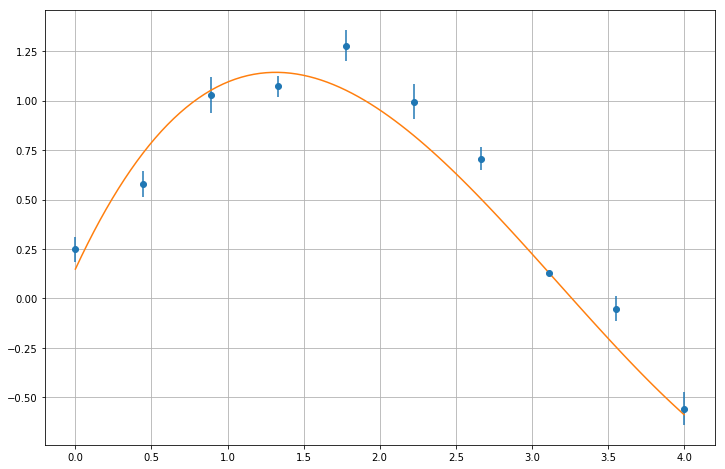

In [36]:
fit = np.polynomial.Polynomial(pars)
plt.figure(figsize=(12,8))
plt.errorbar(x, data, yerr=sigma, fmt='o');
x0 = np.linspace(0, 4, 100)
plt.plot(x0, fit(x0))
plt.grid()

$$\chi^2 = \sum_i \left(\frac{y_i - f(x_i)}{\sigma_i}\right)^2 \to \mathrm{min}$$

In [37]:
def chisq(pars):
    pol = np.polynomial.Polynomial(pars)
    return (((pol(x) - data) / sigma) ** 2).mean()

def chisq_deriv(pars):
    pol = np.polynomial.Polynomial(pars)
    deltay = (pol(x) - data) / sigma
    return 2 * np.array([np.dot(deltay, x**deg) for deg in range(pars.size)]) / deltay.size

In [38]:
fmin, pars = minimize(
    f=chisq,
    grad=chisq_deriv,
    x0=np.array([0.3, 1.5, -0.7, 0.0]),
    lam=1.e-6,
    maxit=5000)
pars

array([ 0.29189937,  1.49442209, -0.69712616,  0.06473831])

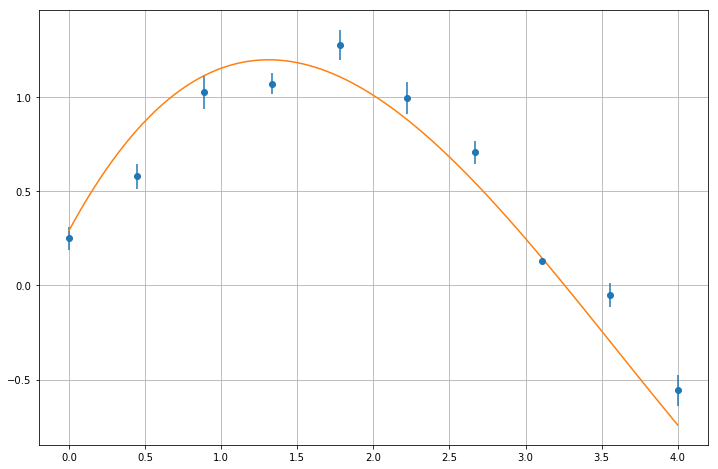

In [39]:
fit = np.polynomial.Polynomial(pars)
plt.figure(figsize=(12,8))
plt.errorbar(x, data, yerr=sigma, fmt='o');
x0 = np.linspace(0, 4, 100)
plt.plot(x0, fit(x0))
plt.grid()

Какова неопределенность в полученных параметрах?

In [40]:
def f2(phi, a, omega, phi0):
    return a * np.cos(omega * phi + phi0)

def f2_deriv(phi, a, omega, phi0):
    return - omega * a * np.sin(omega * phi + phi0)

In [41]:
x = np.linspace(0, 2*np.pi, 10)
a0, omega0, phi00 = 1.3, 0.6, 0
rng = np.random.default_rng(seed=8)
sigma = 0.02 + 0.08 * rng.uniform(size=x.shape)
data = f2(x, a0, omega0, phi00) + rng.normal(loc=0, scale=sigma, size=x.shape)

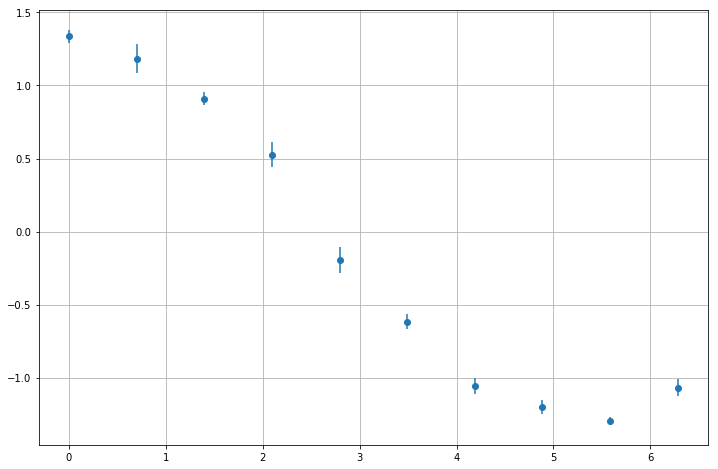

In [42]:
plt.figure(figsize=(12,8))
plt.errorbar(x, data, yerr=sigma, fmt='o');
plt.grid()

In [43]:
pars, covar = optimize.curve_fit(f2, x, data, sigma=sigma)
pars, covar

(array([-1.3084352 ,  0.6002091 ,  3.10888541]),
 array([[ 2.51469787e-04, -4.70810249e-06, -2.69901055e-05],
        [-4.70810249e-06,  1.72165224e-04, -5.41055129e-04],
        [-2.69901055e-05, -5.41055129e-04,  2.08551396e-03]]))

In [44]:
for i, lbl in enumerate(['a', 'omega', 'phi0']):
    print(f'{lbl:>7s} = {pars[i]:+.3f} +- {np.sqrt(covar[i,i]):.3f}')

      a = -1.308 +- 0.016
  omega = +0.600 +- 0.013
   phi0 = +3.109 +- 0.046


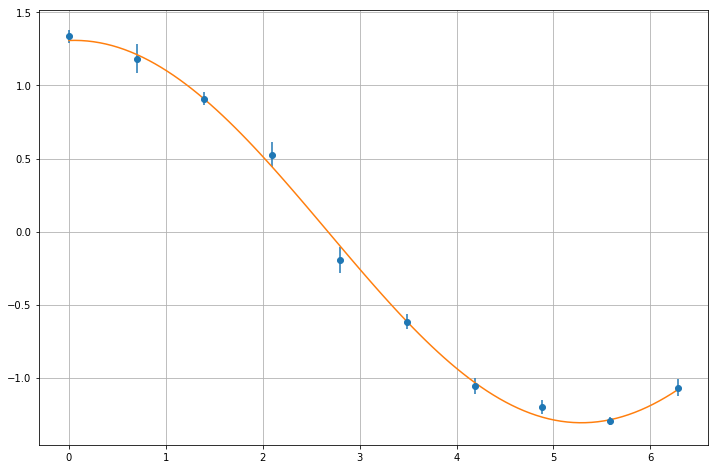

In [45]:
plt.figure(figsize=(12,8))
plt.errorbar(x, data, yerr=sigma, fmt='o');
x0 = np.linspace(0, 2*np.pi, 100)
plt.plot(x0, f2(x0, *pars))
plt.grid()

In [46]:
def chisq(a, omega, phi0):
    return np.sum(((data - f2(x, a, omega, phi0)) / sigma)**2)

In [47]:
chisq(*pars)

4.950453925741625

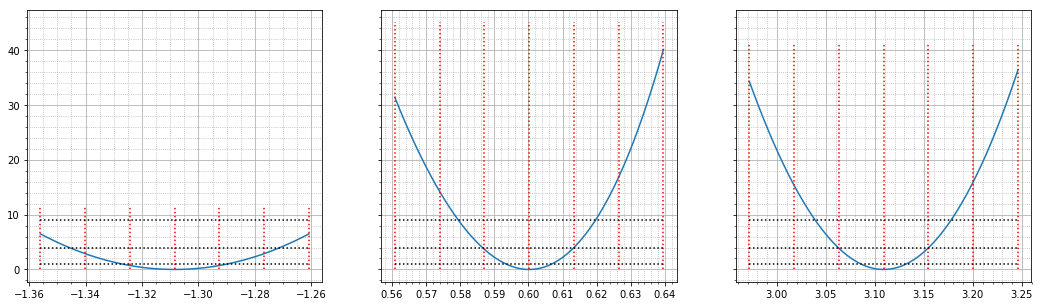

In [48]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)
nsgima = 3
for i, a in enumerate(ax):
    a.minorticks_on()
    a.grid(which='major')
    a.grid(which='minor', linestyle=':')
    p0, s0 = pars[i], np.sqrt(covar[i,i])
    parr = np.linspace(p0 - s0*nsgima, p0 + s0*nsgima, 100)
    chiarr = []
    pars_copy = pars.copy()
    for val in parr:
        pars_copy[i] = val
        chiarr.append(chisq(*pars_copy))
    
    a.plot(parr, chiarr - np.min(chiarr));
    
    for j in range(-3, 4):
        a.plot([p0 + j*s0, p0 + j*s0], [0, np.max(chiarr)], 'r:')
    for j in range(1, 4):
        a.plot([parr[0], parr[-1]], [j**2, j**2], 'k:')

In [49]:
from iminuit import Minuit

In [50]:
m = Minuit(
    chisq, errordef=1,
    a=a0,         error_a=0.1,
    omega=omega0, error_omega=0.1,
    phi0=phi00,   error_phi0=0.1)
mres = m.migrad()
mres

------------------------------------------------------------------
| FCN = 4.95                    |      Ncalls=54 (54 total)      |
| EDM = 1.16E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | a     |   1.308   |   0.019   |            |            |         |         |       |
| 1 | omega |   0.600   |   0.015   |            |            |         |         |       |
| 2 | phi0  |   -0.03   |    0.05   |            |            |         |         |       |
-------------------------------------------------------------------------------------------

In [51]:
pvals = [item.value for item in mres.params]
chisq(*pvals)

4.950465535403896

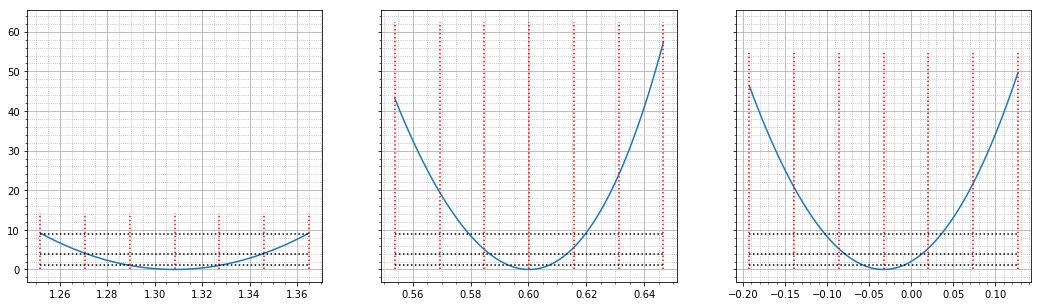

In [52]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)
nsgima = 3
for i, a in enumerate(ax):
    a.minorticks_on()
    a.grid(which='major')
    a.grid(which='minor', linestyle=':')
    p0, s0 = mres.params[i].value, mres.params[i].error
    parr = np.linspace(p0 - s0*nsgima, p0 + s0*nsgima, 100)
    chiarr = []
    pvals = [item.value for item in mres.params]
    for val in parr:
        pvals[i] = val
        chiarr.append(chisq(*pvals))
    
    a.plot(parr, chiarr - np.min(chiarr));
    
    for j in range(-3, 4):
        a.plot([p0 + j*s0, p0 + j*s0], [0, np.max(chiarr)], 'r:')
    for j in range(1, 4):
        a.plot([parr[0], parr[-1]], [j**2, j**2], 'k:')

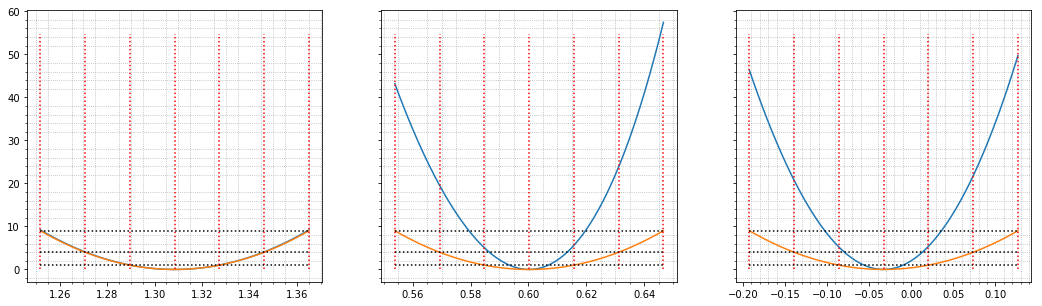

In [53]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)
for i, (a, varname) in enumerate(zip(ax, ['a','omega','phi0'])):
    a.minorticks_on()
    a.grid(which='minor', linestyle=':')
    bins, vals = m.profile(varname, subtract_min=True, bound=3)
    a.plot(bins, vals)
    p0, s0 = mres.params[i].value, mres.params[i].error
    
    x0 = np.linspace(p0 - 3*s0, p0 + 3*s0, 100)
    a.plot(x0, ((x0 - p0)/s0)**2)
    
    for j in range(-3, 4):
        a.plot([p0 + j*s0, p0 + j*s0], [0, np.max(chiarr)], 'r:')
    for j in range(1, 4):
        a.plot([p0 - 3*s0, p0 + 3*s0], [j**2, j**2], 'k:')

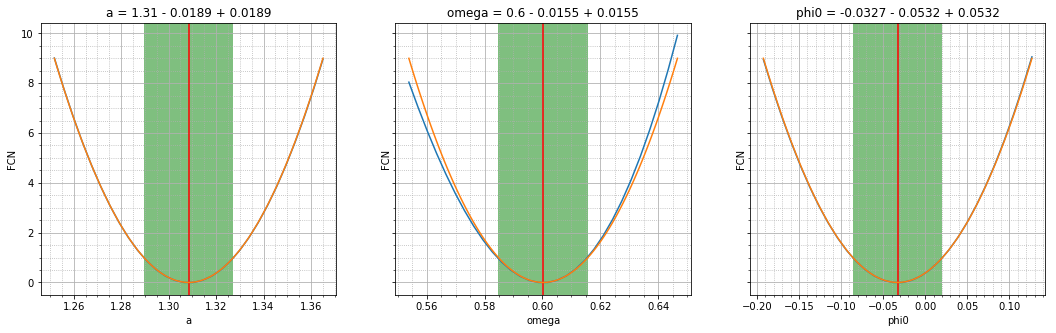

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)
for i, (a, varname) in enumerate(zip(ax, ['a','omega','phi0'])):
    plt.sca(a)
    a.minorticks_on()
    a.grid(which='minor', linestyle=':')
    m.draw_mnprofile(varname, subtract_min=True, bound=3)
    
    p0, s0 = mres.params[i].value, mres.params[i].error
    x0 = np.linspace(p0 - 3*s0, p0 + 3*s0, 100)
    a.plot(x0, ((x0 - p0)/s0)**2)

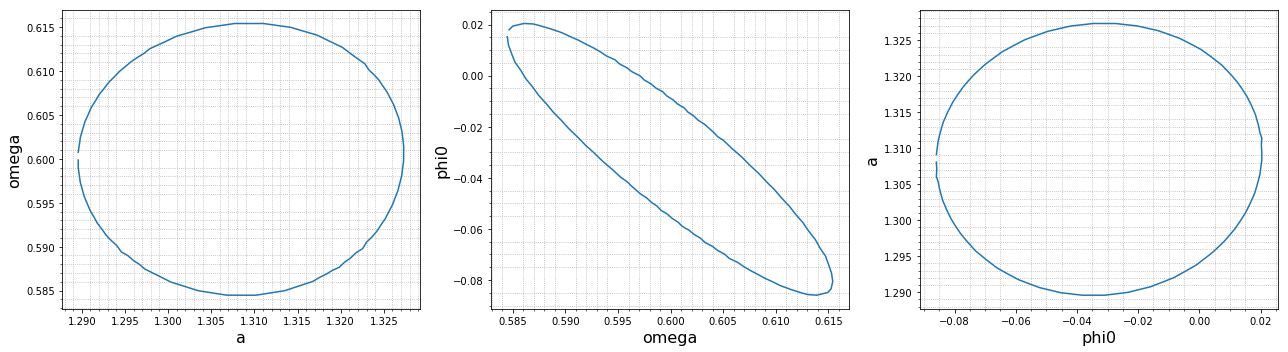

In [55]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
varnames = ['a','omega','phi0']
for i, a in enumerate(ax):
    plt.sca(a)
    a.minorticks_on()
    a.grid(which='minor', linestyle=':')
    err1, err2, contour = m.mncontour(varnames[i%3], varnames[(i+1)%3], numpoints=100)
    p1 = [x[0] for x in contour]
    p2 = [x[1] for x in contour]
    a.set_xlabel(varnames[i%3],fontsize=16)
    a.set_ylabel(varnames[(i+1)%3],fontsize=16)
    a.plot(p1, p2)
fig.tight_layout()

### Нахождение параметров плотности распределения

Дана выборка случайных событий $x_i$, $i=1,..., N$. Известно, что распределение значений подчиняется плотности вероятности $p(\vec{\alpha})$, где $\vec{\alpha}$ - набор неизвестных параметров. Наша задача: найти значения параметров и определить неопреленность этих значений.

**Способ 1**. Сводим к технике $\chi^2$: бинируем данные, и минимизируем $\chi^2$ - сумму отклонений от ожидаемых значений в бине, варьируя $\vec{\alpha}$

**Способ 2**. Метод максимального правдоподобия - в явном виде максимизируем вероятность получения данный выборки, варьируя $\vec{\alpha}$:

$$
\mathcal{L} = \prod\limits_{i}p\left(\vec{\alpha}, x_i\right)\to\mathrm{max}
$$

Работать с произведением многих малых величин неудобно. Кроме того, мы привыкли искать не максимум, а минимум. Нет проблем:

$$
-2\ln{\mathcal{L}} = \sum\limits_i \ln{p\left(\vec{\alpha}, x_i\right)}\to\mathrm{min}
$$

Если $p(x)$ - функция Гаусса, то $-2\ln{\mathcal{L}}$ имеет вид функции $\chi^2$!

In [56]:
sample = np.random.default_rng(seed=11).normal(loc=0.4, scale=0.9, size=10**5)

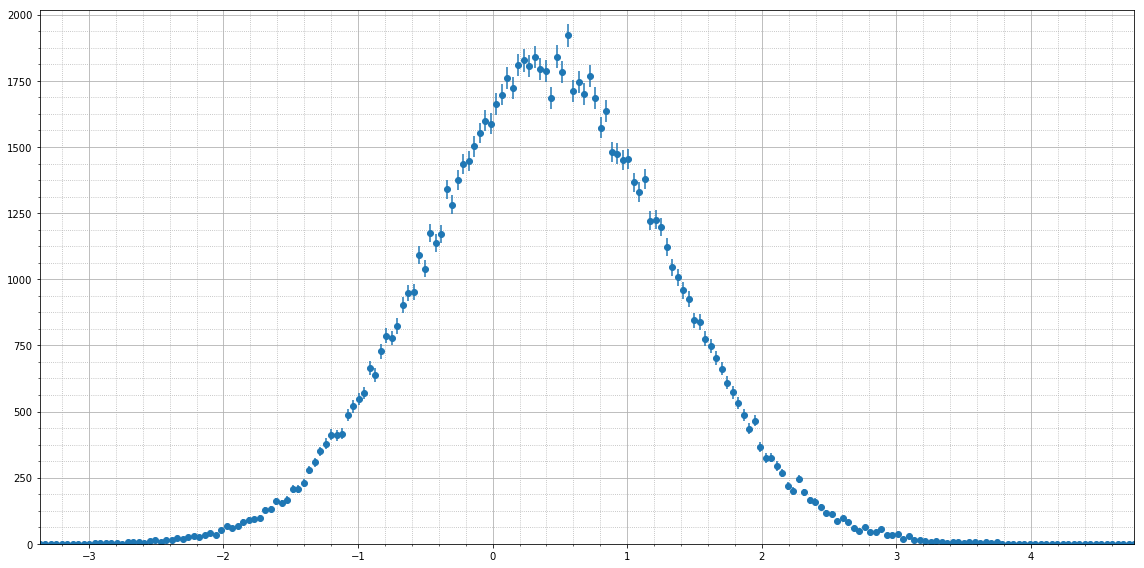

In [57]:
plt.figure(figsize=(16, 8))
hist, bins = np.histogram(sample, bins=200)
bins = 0.5 * (bins[1:] + bins[:-1])
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.ylim((0, 1.05*np.max(hist)))
plt.xlim((bins[0], bins[-1]))
plt.errorbar(bins, hist, yerr=np.sqrt(hist), fmt='o')
plt.tight_layout()

In [58]:
def normdist(x, mu, sigma):
    return np.exp(-0.5*(x - mu)**2 / sigma**2) / (np.sqrt(2*np.pi) * sigma)

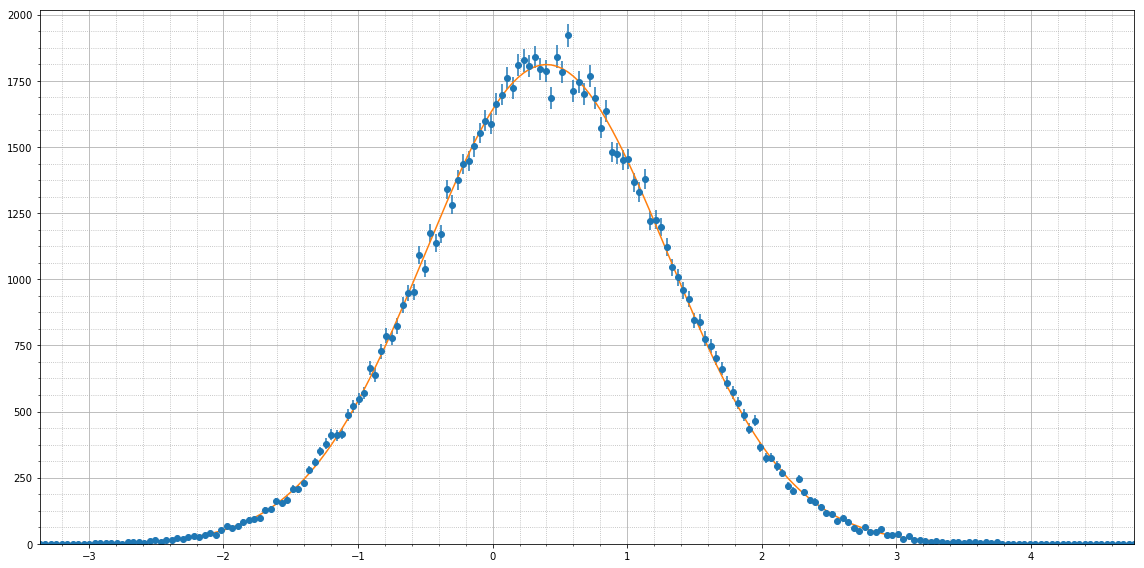

In [59]:
plt.figure(figsize=(16, 8))
hist, bins = np.histogram(sample, bins=200)
bins = 0.5 * (bins[1:] + bins[:-1])
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.ylim((0, 1.05*np.max(hist)))
plt.xlim((bins[0], bins[-1]))
plt.errorbar(bins, hist, yerr=np.sqrt(hist), fmt='o')

x = np.linspace(bins[0], bins[-1], 200)
binsize = bins[1] - bins[0]
plt.plot(x, normdist(x, 0.4, 0.9) * sample.size * binsize)

plt.tight_layout()

In [60]:
def loglh(mu, sigma):
    return -2*np.sum(np.log(normdist(sample, mu, sigma)))

In [61]:
m2 = Minuit(
    loglh, errordef=1,
    mu=0, error_mu=0.4,
    sigma=1, error_sigma=0.4)

In [62]:
mres = m2.migrad()
mres

------------------------------------------------------------------
| FCN = 2.628E+05               |      Ncalls=52 (52 total)      |
| EDM = 1.14E-08 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu    |   0.400   |   0.003   |            |            |         |         |       |
| 1 | sigma |   0.901   |   0.002   |            |            |         |         |       |
-------------------------------------------------------------------------------------------

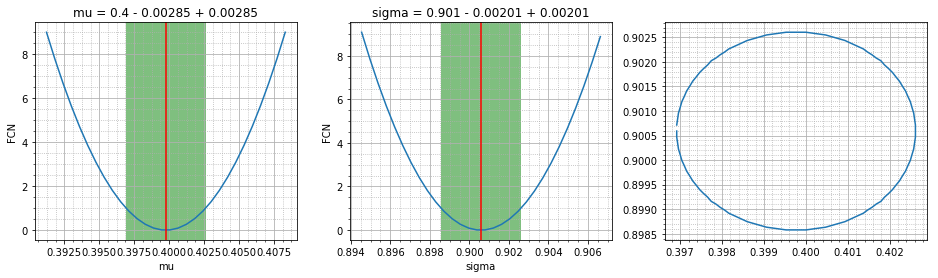

In [63]:
fig, ax = plt.subplots(figsize=(16, 4), ncols=3, sharey=False)
for a, pname in zip(ax, ['mu', 'sigma']):
    plt.sca(a)
    a.minorticks_on()
    a.grid(which='minor', linestyle=':')
    m2.draw_mnprofile(pname, subtract_min=True, bound=3)
err1, err2, contour = m2.mncontour('mu', 'sigma', numpoints=100)
p1 = [x[0] for x in contour]
p2 = [x[1] for x in contour]
ax[-1].plot(p1, p2);
ax[-1].minorticks_on()
ax[-1].grid(which='minor', linestyle=':')
ax[-1].grid(which='major');